# Functional connectiviy Template 
### (Regressor)
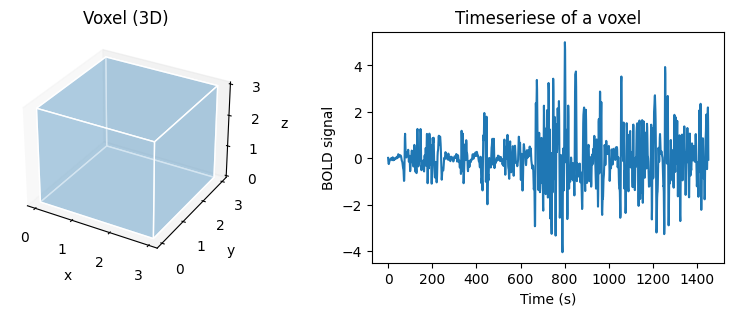

In [2]:
# Import necessary libraries
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt

from nilearn import datasets, maskers, plotting
from nilearn.maskers import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure


# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch
import optuna
import torch_directml
import torch.nn as nn
import torch.optim as optim
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from torch.utils.data import DataLoader, TensorDataset, Subset

# Device selection: DirectML or fallback to CUDA/CPU
#DEVICE = torch_directml.device() if torch_directml.is_available() else torch.device('cuda' if torch.cuda.is_available() else 'cpu')

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")




Using device: cpu


In [4]:
# Functions

def fetch_func_files(wdir, file_suffix='_bold.nii.gz'):
    # Construct the search pattern using the file suffix
    pattern = f'**/*{file_suffix}'
    
    # Convert wdir to a Path object if it's not already one
    wdir = Path(wdir)
    
    # Use glob to find and sort the files matching the pattern
    func_files = sorted(glob(str(wdir / pattern), recursive=True))
    
    # Print the number of files found
    print(f"Number of functional files with suffix '{file_suffix}': {len(func_files)}")
    
    # Return the list of functional file paths
    return func_files
# data = fetch_func_files(wdir, file_suffix='_bold.nii.gz' )

def fetch_dss_files(wdir, task_name='rest'):
    # Construct the search pattern based on the task name
    pattern = f'**/sub-*/func/*task-{task_name}_bold.nii.gz'

    
    # Convert wdir to a Path object if it's not already one
    wdir = Path(wdir)
    
    # Use glob to find and sort the files matching the pattern
    func_files = sorted(glob(str(wdir / pattern), recursive=True))
    
    # Print the number of files found
    print(f"Number of '{task_name}' functional files: {len(func_files)}")
    
    # Return the list of functional file paths
    return func_files
# data_func = fetch_dss_files(wdir, task_name='rest')

def load_json_file(file_name, data_dir):

    data_dir = Path(data_dir)
    file_path = data_dir / file_name
    
    # Check if the file exists
    if not file_path.exists():
        raise FileNotFoundError(f"The file {file_path} does not exist.")
    
    # Read the JSON file
    with file_path.open('r', encoding='utf-8') as file:
        data = json.load(file)
    
    # Print the contents of the JSON file
    print(json.dumps(data, indent=4))
    
    return data
# df_description = load_json_file("dataset_description.json", data_dir=wdir)


In [5]:
# Shortcuts

#dataset = datasets.fetch_adhd(n_subjects=None, data_dir=None, url=None, resume=True, verbose=1)

#dataset = datasets.fetch_openneuro_dataset(urls=None, data_dir=None, dataset_version='ds000030_R1.0.5', verbose=1)[source]

#dataset = datasets.fetch_abide_pcp(n_subjects=None, data_dir=None, url=None)

#dataset = datasets.fetch_development_fmri()

#pheno = pd.DataFrame(dataset.phenotypic)

#print('Keys:',list(data.keys()))
#print('Number of subjects:', len(data.func))
#print('Description:',data.description)

#---------------------------------------------


#wdir = r'C:\Users\lacom\nilearn_data\development_fmri\development_fmri'

#data_func = sorted(glob(os.path.join(wdir,'*.gz')))
#confounds = sorted(glob(os.path.join(wdir,'*desc-confounds_regressors.tsv')))

#print ('Func Data:',len(data))
#print ('Confounds:',len(confounds))

#pheno_path = os.path.join(wdir, 'participants.tsv')
#pheno = pd.read_csv(pheno_path, sep='\t').sort_values('participant_id')
#pheno.head()

## Load the data

In [6]:
dataset = datasets.fetch_development_fmri()

print('Keys:',list(dataset.keys()))
print('Number of subjects:', len(dataset.func))

Keys: ['func', 'confounds', 'phenotypic', 'description']
Number of subjects: 155


In [7]:
data = dataset.func

In [8]:
fmri_filenames = data[5]
print(fmri_filenames)

C:\Users\lacom/nilearn_data\development_fmri\development_fmri\sub-pixar128_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz


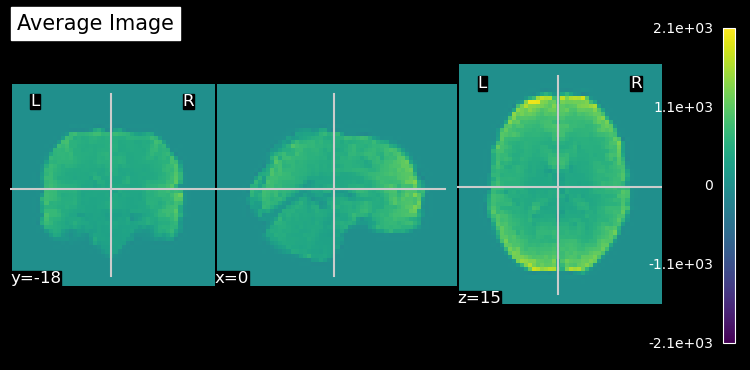

In [9]:
from nilearn import image 
averaged_Img = image.mean_img(image.mean_img(fmri_filenames))
plotting.plot_stat_map(averaged_Img,title='Average Image', cmap='viridis',threshold=0.1, dim=-2, colorbar=True,black_bg=True)

In [10]:
confounds = dataset.confounds
conf = confounds[5]
conf_df = pd.read_table(conf)
conf_df.head()

,trans_x,trans_y,trans_z,rot_x,rot_y,rot_z,framewise_displacement,a_comp_cor_00,a_comp_cor_01,a_comp_cor_02,a_comp_cor_03,a_comp_cor_04,a_comp_cor_05,csf,white_matter
0,0.000000,0.000000,0.000000,0.000000,-0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,525.521464,473.476960
1,0.002290,0.039488,-0.000004,0.000000,0.000190,0.0,0.051301,-0.009419,0.064324,-0.046474,0.006744,-0.007179,0.025285,529.577966,476.734232
2,-0.000011,-0.104030,-0.009560,0.000164,0.000366,0.0,0.172322,-0.013124,0.010970,0.072557,0.030795,0.015773,-0.063280,531.250261,476.517911
3,-0.000031,0.169104,0.013041,-0.000843,0.000453,0.0,0.350465,0.033150,0.025784,0.036211,0.005530,0.048968,-0.025824,531.240585,476.460569
4,-0.000061,-0.145348,-0.025025,0.000060,0.000386,0.0,0.401084,-0.035600,-0.035397,-0.127860,0.001092,-0.031902,0.048258,531.931781,476.174483


### Explore the Target Variable (Y)

In [11]:
pheno = pd.DataFrame(dataset.phenotypic)
pheno.head()

,participant_id,Age,AgeGroup,Child_Adult,Gender,Handedness
0,sub-pixar123,27.06,Adult,adult,F,R
1,sub-pixar124,33.44,Adult,adult,M,R
2,sub-pixar125,31.00,Adult,adult,M,R
3,sub-pixar126,19.00,Adult,adult,F,R
4,sub-pixar127,23.00,Adult,adult,F,R


In [12]:
# INFO

# Display the shape of the data
print("Data Shape:")
print(pheno.shape)

# Check for any duplicate entries in the data.
print('')
print("Duplicate Values:")
print('(',pheno.duplicated().sum(),')')


# Display the data types of the columns
print("\nData Types:")
print(pheno.dtypes.value_counts())

# Check for missing values
missing_columns = pheno.columns[pheno.isnull().any()]
if missing_columns.size > 0:
    missing_values = pheno[missing_columns].isnull().sum()
    missing_percentage = (missing_values / len(pheno)) * 100

    # Combine missing_values and missing_percentage into a single DataFrame
    missing_data = pd.concat([missing_values, missing_percentage], axis=1, keys=['Total', 'Percent'])

    # Sort the missing_data DataFrame by Total column in descending order
    missing_data = missing_data.sort_values(by='Total', ascending=False)

    # Print missing data
    print("\nMissing Data:")
    print(missing_data.to_string())
else:
    print("\nNo Missing Values Found")



Data Shape:
(155, 6)

Duplicate Values:
( 0 )

Data Types:
object     5
float64    1
Name: count, dtype: int64

No Missing Values Found


In [13]:
pheno.columns

Index(['participant_id', 'Age', 'AgeGroup', 'Child_Adult', 'Gender',
       'Handedness'],
      dtype='object')

In [14]:
pheno[['participant_id', 'Age', 'Gender']].sample(10)

,participant_id,Age,Gender
79,sub-pixar047,5.470000,F
88,sub-pixar056,5.260000,F
149,sub-pixar117,12.300000,M
133,sub-pixar101,11.170000,M
95,sub-pixar063,5.330000,M
63,sub-pixar031,4.084873,F
151,sub-pixar119,8.620000,F
150,sub-pixar118,10.500000,F
86,sub-pixar054,5.990000,M
120,sub-pixar088,7.710000,M


In [15]:
print('Number of classes:',pheno['Child_Adult'].value_counts())

Number of classes: Child_Adult
child    122
adult     33
Name: count, dtype: int64


Number of classes: ['F' 'M']
Gender
F    84
M    71
Name: count, dtype: int64


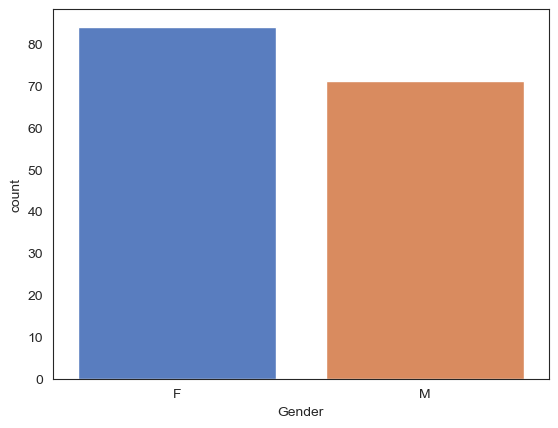

In [16]:
sex = pheno['Gender']

print('Number of classes:',sex.unique())

sns.set_style("white")
sns.set_palette("muted")
sns.countplot(x= sex)

print(sex.value_counts())

**AGE DISTRIBUTION**

Asymmetry: 1.544492
Kurtosis: 1.425876


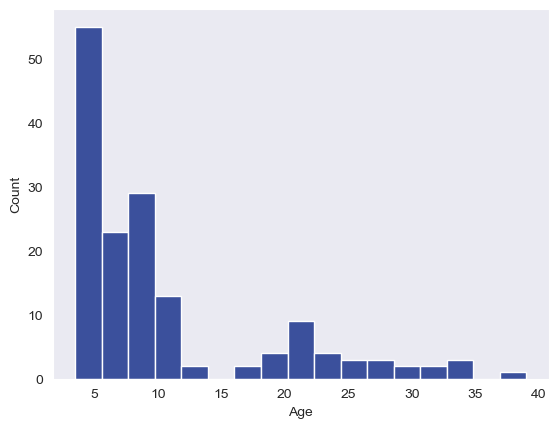

In [17]:
age = pheno['Age']

sns.set_style("dark")
sns.set_palette("dark")
sns.histplot(age)

#skewness and kurtosis
print("Asymmetry: %f" % age.skew())
print("Kurtosis: %f" % age.kurt())

In [18]:
# Group by column
diagnosis = pheno.groupby('Child_Adult')

# Calculate descriptive statistics
diagnosis['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Child_Adult,,,,,,,,
adult,33.0,24.772727,5.308521,18.000000,21.00000,23.00,28.0000,39.0
child,122.0,6.709461,2.330938,3.518138,4.89521,5.98,8.3975,12.3


### Probabilistic Atlas
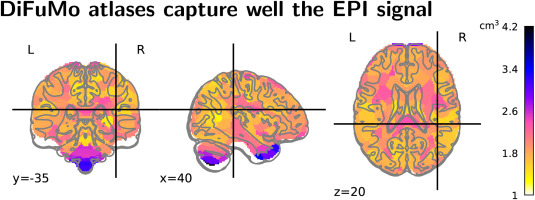

In [19]:
dim = 64
difumo = datasets.fetch_atlas_difumo(
    dimension=dim, resolution_mm=2, legacy_format=False
)

atlas_filename = difumo.maps




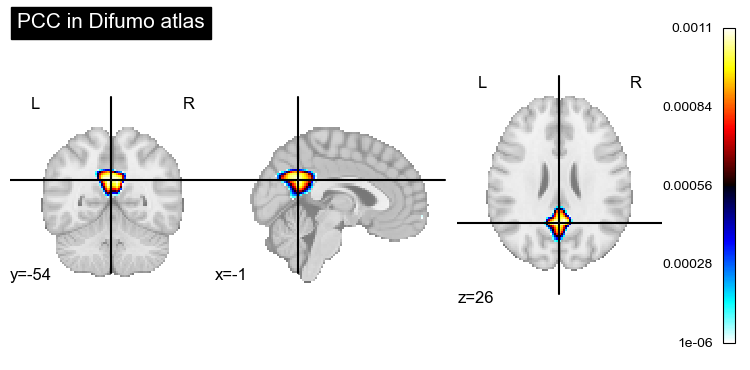

In [20]:
from nilearn import image, plotting

# First plot the map for the PCC: index 3 in the atlas
display = plotting.plot_stat_map(
    image.index_img(atlas_filename, 3),
    colorbar=True,
    title="PCC in Difumo atlas",
)

plotting.show()

In [21]:
difumo.labels

,component,difumo_names,yeo_networks7,yeo_networks17,gm,wm,csf
0,1,Superior frontal sulcus,DefaultB,DefaultA,0.689996,0.185709,0.116884
1,2,Fusiform gyrus,No network found,No network found,0.844733,0.021026,0.133789
2,3,Calcarine cortex posterior,VisCent,VisPeri,0.601768,0.302067,0.091297
3,4,Cingulate cortex posterior,DefaultB,DefaultA,0.740086,0.140368,0.119567
4,5,Parieto-occipital sulcus superior,ContA,ContC,0.640157,0.241492,0.117826
...,...,...,...,...,...,...,...
59,60,Cuneus,VisCent,VisPeri,0.627179,0.269783,0.103005
60,61,Middle temporal gyrus,DefaultB,DefaultB,0.726527,0.149595,0.107329
61,62,Superior frontal gyrus,DefaultB,DefaultB,0.651182,0.062243,0.224067
62,63,Central sulcus,SomMotA,SomMotB,0.578502,0.291674,0.109244


### Extract features with nilearn masker

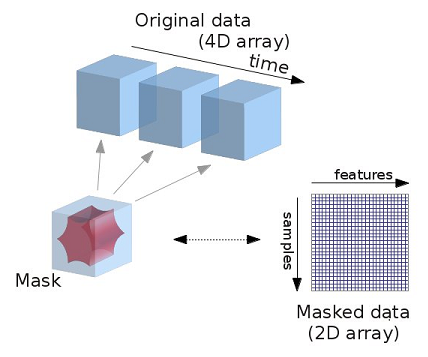 

Compute a correlation matrix, representing regional coactivation between regions and extract signals from a brain parcellation 


In [22]:
from nilearn.maskers import MultiNiftiMapsMasker
from nilearn.connectome import ConnectivityMeasure

# create masker using MultiNiftiMapsMasker to extract functional data within
# atlas parcels from multiple subjects using parallelization to speed up the
# # computation
masker = MultiNiftiMapsMasker(
    maps_img=atlas_filename,
    standardize='zscore_sample',
    standardize_confounds='zscore_sample',
    memory='nilearn_cache',
    n_jobs=2, verbose=0
)

# ConenctivityMeasure from Nilearn uses simple 'correlation' to compute
# connectivity matrices for all subjects in a list
connectome_measure = ConnectivityMeasure(
    kind='correlation', vectorize=True, discard_diagonal=True)




In [23]:
# METHOD 2

# extract time series from all subjects
#time_series = masker.fit_transform(data, confounds=data_confounds)

# calculate correlation matrices across subjects and display
#correlation_matrices = connectome_measure.fit_transform(time_series)

In [24]:
data[:4]

['C:\\Users\\lacom/nilearn_data\\development_fmri\\development_fmri\\sub-pixar123_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 'C:\\Users\\lacom/nilearn_data\\development_fmri\\development_fmri\\sub-pixar124_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 'C:\\Users\\lacom/nilearn_data\\development_fmri\\development_fmri\\sub-pixar125_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz',
 'C:\\Users\\lacom/nilearn_data\\development_fmri\\development_fmri\\sub-pixar126_task-pixar_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz']

**Extract fMRI connectivity features from every subject.**



In [25]:
# all_features = [connectome_measure.fit_transform([masker.fit_transform(sub, confounds=confounds[i])])[0] for i, sub in enumerate(data)]

In [26]:
# Let's save the data to disk

# np.savez_compressed('Age_Regressor_featuress.npz',a = all_features)

In [27]:
# Load the features

feat_file = 'Age_Regressor_featuress.npz'
X_features = np.load(feat_file)['a']

print('Features shape:', X_features.shape)

Features shape: (155, 2016)


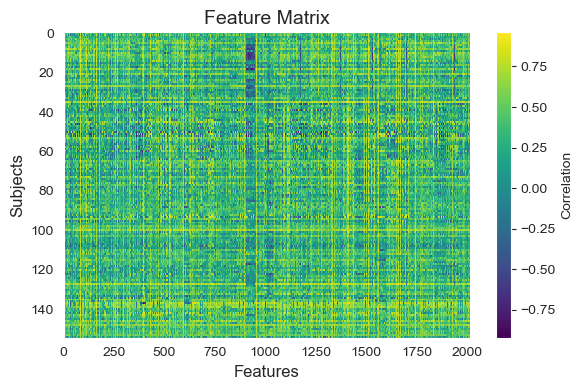

In [28]:
# Create the plot
plt.figure(figsize=(6, 4))
plt.imshow(X_features, aspect='auto', cmap='viridis', interpolation='nearest')

# Add colorbar
plt.colorbar(label='Correlation')

# Add title and labels
plt.title('Feature Matrix', fontsize=14)
plt.xlabel('Features', fontsize=12)
plt.ylabel('Subjects', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


## Prepare data for machine learning

In [29]:
# Select features and target
X = X_features
y = pheno['Age'].values

# Convert to PyTorch tensors
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [30]:
# Constants
TEST_SIZE = 0.2  # Example test size
RANDOM_STATE = 42  # Example random state
BATCH_SIZE = 32  # Example batch size

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True)

# DataLoader
train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=BATCH_SIZE, shuffle=False)

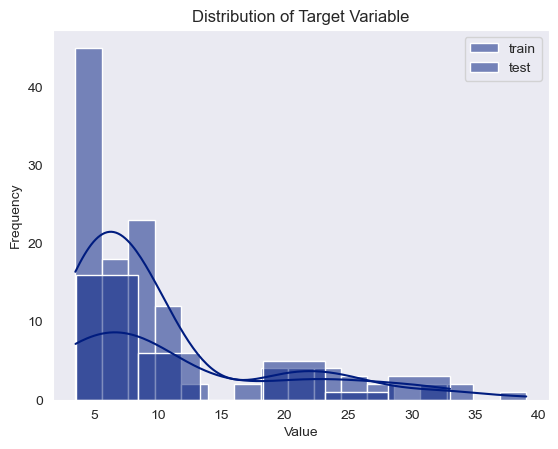

training: 124 testing: 31


In [31]:
# Check data distribution
sns.histplot(y_train, label='train', kde=True)
sns.histplot(y_test, label='test', kde=True)
plt.legend()
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of Target Variable')
plt.show()

# Print the size of the training and test sets
print('training:', len(X_train), 'testing:', len(X_test))


In [32]:
'''Regression Linear Model

from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV, train_test_split

# Create an instance of the Support Vector Regressor
svr_model = SVR()  

# Define hyperparameters to tune
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'kernel': ['linear'],  # Kernel types: linear and radial basis function
    'gamma': ['scale', 'auto', 0.1, 1, 10]  # Kernel coefficient for 'rbf' kernel
}

# Define cross-validation technique (Stratified K-Fold is not used for regression)
cv = 5  # Number of folds for cross-validation

# Perform grid search cross-validation
grid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=cv)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

print("Best Parameters:", best_params)

# Import necessary libraries
from sklearn.metrics import mean_squared_error, r2_score

# Train the model with the best parameters
best_svr_model = SVR(**best_params)
best_svr_model.fit(X_train, y_train)

# Make predictions on the test data
y_pred = best_svr_model.predict(X_test)

# Calculate R-squared
r_squared = r2_score(y_test, y_pred)

# Calculate mean squared error (MSE) as well
mse = mean_squared_error(y_test, y_pred)

# Print results

print("Mean Squared Error (MSE):", mse)
print("R-squared (R2):", r_squared)

correlation_measure = connectome_measure

connectome_measure.inverse_transform(best_svr_model.coef_).shape

# Extract support vectors and their coefficients
support_vectors = best_svr_model.support_vectors_
dual_coef = best_svr_model.dual_coef_

# Calculate the importance of features using the support vectors and dual coefficients
feature_importance = np.dot(dual_coef, support_vectors)

# Inverse transform to the original feature space if needed
inverse_transformed_feature_importance = connectome_measure.inverse_transform(feature_importance)

# Shape of the inverse transformed feature importance
shape = inverse_transformed_feature_importance.shape

# Extract support vectors and their coefficients
support_vectors = best_svr_model.support_vectors_
dual_coef = best_svr_model.dual_coef_

# Calculate the importance of features using the support vectors and dual coefficients
feature_importance = np.dot(dual_coef, support_vectors)

# Inverse transform to the original feature space if needed
inverse_transformed_feature_importance = connectome_measure.inverse_transform(feature_importance)

# Shape of the inverse transformed feature importance
shape = inverse_transformed_feature_importance.shape

# Get the coefficients (weights) of the linear SVM model from best_estimator
coefficients = best_svr_model.coef_



plt.bar(range(coefficients.shape[-1]),coefficients[0])
plt.gca().set_facecolor('purple')  # Change background color
plt.title('feature importances')
plt.xlabel('feature')
plt.ylabel('weight')

feat_exp_matrix = correlation_measure.inverse_transform(best_svr_model.coef_)[0]

# Define a threshold to visualize only higher values
threshold = 0.05  # Adjust this threshold as needed

labels = difumo.labels["difumo_names"]

# Replace diagonal with NaN to remove it from the plot
np.fill_diagonal(feat_exp_matrix, np.nan)

# Plot the matrix
plt.figure(figsize=(20, 18))  # Adjust the figure size as needed
plt.imshow(feat_exp_matrix, cmap='viridis', origin='upper', vmin=threshold)
plt.colorbar(label='Correlation Strength', fraction=0.046, pad=0.04)  # Adjust color bar position

# Add labels to the ticks
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.yticks(ticks=range(len(labels)), labels=labels)

# Add title
plt.title('Connectivity Matrix')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()


# Define a threshold to visualize only higher values
threshold = 0.5  # Adjust this threshold as needed

# Iterate over the correlation matrix and print the values
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and feat_exp_matrix[i, j] >= threshold:
            print(f"{labels[i]} - {labels[j]}: {feat_exp_matrix[i, j]}")


# grab center coordinates for probabilistic atlas
coords = plotting.find_probabilistic_atlas_cut_coords(
    maps_img=difumo.maps
)

# plot connectome with 85% edge strength in the connectivity
plotting.plot_connectome(
    feat_exp_matrix,
    coords,
    edge_cmap='plasma',
    colorbar=True,
    edge_threshold="99%",
    title=f"DiFuMo with {dim} dimensions (probabilistic)",
)
plotting.show()

plotting.view_connectome(feat_exp_matrix, coords, edge_threshold='99%',
                        edge_cmap='plasma', colorbar=True)

p_threshold = 0.4  

# Iterate over the correlation matrix and print the values
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and feat_exp_matrix[i, j] >= p_threshold:
            print(f"{labels[i]} - {labels[j]}: {feat_exp_matrix[i, j]}")

n_threshold = -0.4  

# Iterate over the correlation matrix and print the values
for i in range(len(labels)):
    for j in range(len(labels)):
        if i != j and feat_exp_matrix[i, j] < n_threshold:
            print(f"{labels[i]} - {labels[j]}: {feat_exp_matrix[i, j]}")

'''

'Regression Linear Model\n\nfrom sklearn.svm import SVR\nfrom sklearn.model_selection import GridSearchCV, train_test_split\n\n# Create an instance of the Support Vector Regressor\nsvr_model = SVR()  \n\n# Define hyperparameters to tune\nparam_grid = {\n    \'C\': [0.01, 0.1, 1, 10, 100],  # Regularization parameter\n    \'kernel\': [\'linear\'],  # Kernel types: linear and radial basis function\n    \'gamma\': [\'scale\', \'auto\', 0.1, 1, 10]  # Kernel coefficient for \'rbf\' kernel\n}\n\n# Define cross-validation technique (Stratified K-Fold is not used for regression)\ncv = 5  # Number of folds for cross-validation\n\n# Perform grid search cross-validation\ngrid_search = GridSearchCV(estimator=svr_model, param_grid=param_grid, cv=cv)\ngrid_search.fit(X_train, y_train)\n\n# Get the best parameters\nbest_params = grid_search.best_params_\n\nprint("Best Parameters:", best_params)\n\n# Import necessary libraries\nfrom sklearn.metrics import mean_squared_error, r2_score\n\n# Train the m

## **Non-Linear Model**

In [33]:
# Assuming you have labels from difumo
labels = difumo.labels["difumo_names"]

# Generate feature names and indices
feature_names = [f'{labels[i]} - {labels[j]}' for i in range(64) for j in range(i + 1, 64)]
feature_indices = list(range(1, len(feature_names) + 1))

# Create a DataFrame
feature_mapping_df = pd.DataFrame({
    'Feature Index': feature_indices,
    'Feature Name': feature_names
})

# Display a sample of the feature mapping DataFrame
feature_mapping_df.head(5)

,Feature Index,Feature Name
0,1,Superior frontal sulcus - Fusiform gyrus
1,2,Superior frontal sulcus - Calcarine cortex pos...
2,3,Superior frontal sulcus - Cingulate cortex pos...
3,4,Superior frontal sulcus - Parieto-occipital su...
4,5,Superior frontal sulcus - Insula antero-superior


In [34]:
# Model Definition
class RegressionModel(nn.Module):
    def __init__(self, input_dim, hidden_layers, dropout_rate):
        super(RegressionModel, self).__init__()
        layers = []
        last_dim = input_dim
        
        for hidden_dim in hidden_layers:
            layers.append(nn.Linear(last_dim, hidden_dim))
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(dropout_rate))
            last_dim = hidden_dim
            
        layers.append(nn.Linear(last_dim, 1))  # Single output for regression
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

# Hyperparameter Optimization Function
def objective(trial):
    # Suggest hyperparameters
    hidden_layers_options = [
        (256, 128),  # Converted to tuples
        (512, 256, 128),  # Converted to tuples
        (512, 256)  # Converted to tuples
    ]
    hidden_layers = trial.suggest_categorical('hidden_layers', hidden_layers_options)
    dropout_rate = trial.suggest_float('dropout_rate', 0.2, 0.5)
    lr = trial.suggest_float('lr', 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float('weight_decay', 1e-6, 1e-3, log=True)

    # Model and optimizer
    model = RegressionModel(input_dim=X_train.shape[1], hidden_layers=hidden_layers, dropout_rate=dropout_rate).to(DEVICE)
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=MAX_EPOCHS_OPTUNA)
    
    # Training loop
    best_loss = float('inf')
    no_improvement = 0
    patience = 10

    for epoch in range(MAX_EPOCHS_OPTUNA):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_loss = sum(criterion(model(inputs.to(DEVICE)), labels.to(DEVICE)).item() for inputs, labels in test_loader) / len(test_loader)
        
        scheduler.step()
        
        # Early stopping
        if val_loss < best_loss - 1e-3:
            best_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return val_loss

# Create study and optimize
MAX_EPOCHS_OPTUNA = 20  # Example maximum number of epochs
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=20, n_jobs=4)

# Best model parameters
best_params = study.best_params
print(f"Best hyperparameters: {best_params}")



[I 2024-08-25 10:41:27,381] A new study created in memory with name: no-name-5527ea38-9285-48d5-850a-42303942191d


[I 2024-08-25 10:41:39,815] Trial 3 finished with value: 225.70350646972656 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.4276651384913327, 'lr': 1.4811464144575868e-05, 'weight_decay': 2.882161404999744e-05}. Best is trial 3 with value: 225.70350646972656.


Early stopping at epoch 11


[I 2024-08-25 10:41:41,843] Trial 0 finished with value: 165.0966033935547 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.28288544497221507, 'lr': 0.0002182888088345584, 'weight_decay': 1.6692756540792468e-05}. Best is trial 0 with value: 165.0966033935547.
[I 2024-08-25 10:41:41,924] Trial 2 finished with value: 14.490660667419434 and parameters: {'hidden_layers': (256, 128), 'dropout_rate': 0.440207884925685, 'lr': 0.004383273863021697, 'weight_decay': 0.00021751883296236896}. Best is trial 2 with value: 14.490660667419434.
[I 2024-08-25 10:41:43,388] Trial 1 finished with value: 23.00075912475586 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.3211836016161663, 'lr': 0.0031117615810427133, 'weight_decay': 5.021789387871318e-06}. Best is trial 2 with value: 14.490660667419434.
[I 2024-08-25 10:41:45,403] Trial 4 finished with value: 113.82585906982422 and parameters: {'hidden_layers': (512, 256, 128), 'dropout_rate': 0.4020645320036388, 'lr': 0.0

Early stopping at epoch 18


[I 2024-08-25 10:41:58,549] Trial 16 finished with value: 17.007137298583984 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3573416588276045, 'lr': 0.008980770625454812, 'weight_decay': 1.0049823231404587e-06}. Best is trial 14 with value: 14.196131706237793.


Early stopping at epoch 17


[I 2024-08-25 10:41:58,887] Trial 15 finished with value: 15.686352729797363 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.49996100770673396, 'lr': 0.008988331279158912, 'weight_decay': 1.417560136408053e-06}. Best is trial 14 with value: 14.196131706237793.


Early stopping at epoch 18


[I 2024-08-25 10:42:02,166] Trial 17 finished with value: 14.168473243713379 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.36680851744866505, 'lr': 0.009750939993933807, 'weight_decay': 1.1115046226564943e-06}. Best is trial 17 with value: 14.168473243713379.


Early stopping at epoch 15


[I 2024-08-25 10:42:03,057] Trial 18 finished with value: 18.080989837646484 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.37804041844933534, 'lr': 0.007634003727809275, 'weight_decay': 1.21836538114556e-06}. Best is trial 17 with value: 14.168473243713379.


Early stopping at epoch 16


[I 2024-08-25 10:42:03,746] Trial 19 finished with value: 18.316726684570312 and parameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.3755984592719034, 'lr': 0.003513365273548355, 'weight_decay': 1.066855000618015e-06}. Best is trial 17 with value: 14.168473243713379.


Best hyperparameters: {'hidden_layers': (512, 256), 'dropout_rate': 0.36680851744866505, 'lr': 0.009750939993933807, 'weight_decay': 1.1115046226564943e-06}


In [35]:
# Model Training Function
def train_model(model, train_loader, test_loader, criterion, optimizer, scheduler, max_epochs, patience):
    best_loss = float('inf')
    no_improvement = 0

    for epoch in range(max_epochs):
        model.train()
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()
        with torch.no_grad():
            val_loss = sum(criterion(model(inputs.to(DEVICE)), labels.to(DEVICE)).item() for inputs, labels in test_loader) / len(test_loader)
        
        scheduler.step()

        # Early stopping
        if val_loss < best_loss - 1e-3:
            best_loss = val_loss
            no_improvement = 0
        else:
            no_improvement += 1

        if no_improvement >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

    return model

# Evaluate model
def evaluate_model(model, X_test, y_test):
    model.eval()
    with torch.no_grad():
        pred = model(X_test.to(DEVICE)).cpu().numpy().flatten()
        mse = metrics.mean_squared_error(y_test.cpu(), pred)
        mae = metrics.mean_absolute_error(y_test.cpu(), pred)
        r2 = metrics.r2_score(y_test.cpu(), pred)
    return mse, mae, r2

# Final Model
# Train final model with best parameters
MAX_EPOCHS_FINAL = 50  # Example final maximum number of epochs
PATIENCE = 10  # Example patience for early stopping

best_model = RegressionModel(input_dim=X_train.shape[1], hidden_layers=best_params['hidden_layers'], 
                             dropout_rate=best_params['dropout_rate']).to(DEVICE)
best_optimizer = optim.AdamW(best_model.parameters(), lr=best_params['lr'], weight_decay=best_params['weight_decay'])
best_scheduler = optim.lr_scheduler.CosineAnnealingLR(best_optimizer, T_max=MAX_EPOCHS_FINAL)

# Function to train the final model (assuming `train_model` is defined)
final_model = train_model(best_model, train_loader, test_loader, nn.MSELoss(), best_optimizer, best_scheduler, MAX_EPOCHS_FINAL, PATIENCE)


mse, mae, r2 = evaluate_model(final_model, X_test, y_test)
print(f"Validation MSE: {mse}")
print(f"Validation MAE: {mae}")
print(f"Validation R^2: {r2}")


Early stopping at epoch 18
Validation MSE: 18.481361389160156
Validation MAE: 3.010016918182373
Validation R^2: 0.7674963261469459


In [46]:
# Feature Importance
def perturbation_rank(model, X_test, y_test, feature_names):
    model.eval()
    baseline_loss = nn.MSELoss()(model(X_test.to(DEVICE)), y_test.to(DEVICE)).item()
    importance_scores = []

    for i in range(X_test.shape[1]):
        X_test_perturbed = X_test.clone()
        X_test_perturbed[:, i] = X_test_perturbed[torch.randperm(X_test_perturbed.size(0)), i]
        perturbed_loss = nn.MSELoss()(model(X_test_perturbed.to(DEVICE)), y_test.to(DEVICE)).item()
        importance = perturbed_loss - baseline_loss
        importance_scores.append(importance)

    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importance_scores
    }).sort_values(by='Importance', ascending=False).reset_index(drop=True)

    return importance_df

# Assuming you have a list of feature names
feature_names = feature_mapping_df['Feature Name'].tolist()
importance_df = perturbation_rank(final_model, X_test, y_test, feature_names)

,Feature,Importance
0,Intraparietal sulcus LH - Cuneus,0.601772
1,Inferior occipital gyrus - Lingual gyrus,0.490822
2,Putamen - Postcentral gyrus inferior,0.444759
3,Calcarine cortex posterior - Cingulate gyrus m...,0.438400
4,Insula antero-superior - Inferior frontal sulcus,0.417381


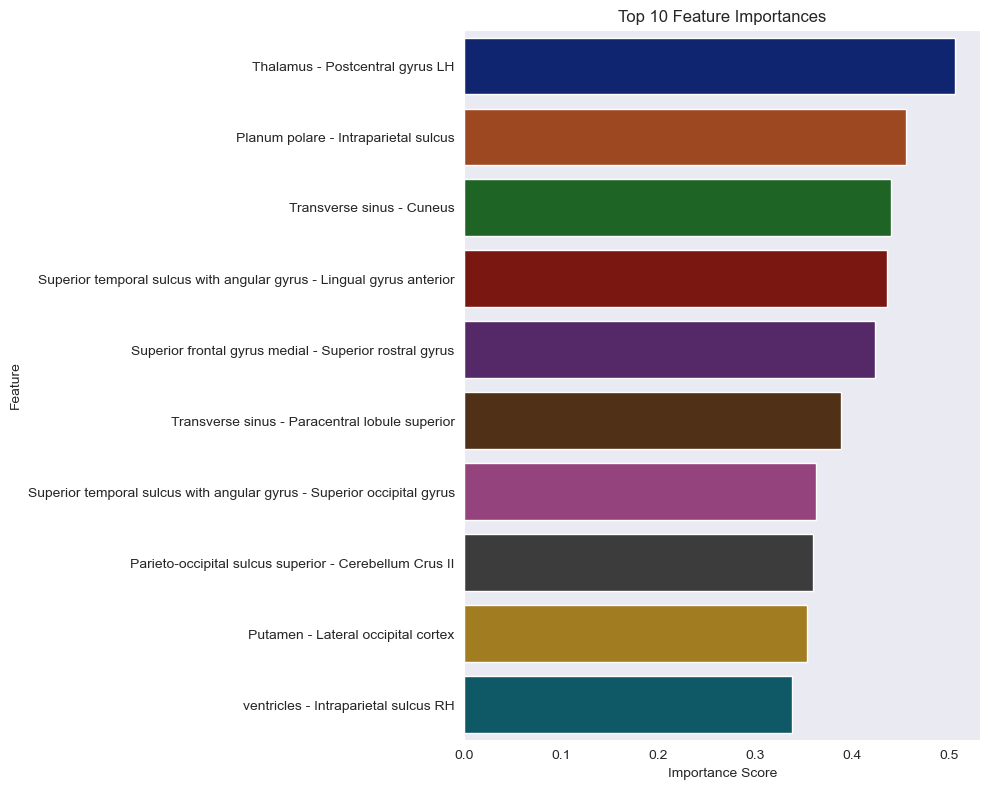

In [45]:
# Plot top 10 feature importances
top_10_feature_importances = importance_df.head(10)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=top_10_feature_importances)
plt.title('Top 10 Feature Importances')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

In [ ]:
importance_df.head(5)